<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [2]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta

import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [3]:
os.listdir()

['.config',
 'match_result_test.csv',
 'sales.csv',
 'sample-sales-data.csv',
 'ecommerce-data.csv',
 'mall_customers.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sales_data_with_stores.csv',
 '1_order_payments_dataset.csv',
 'scanner_data.csv',
 '1_orders_dataset.csv',
 'test.csv',
 'bz_data_analyis.csv',
 'groceries.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 '1_customers_dataset.csv',
 'online_retail_II.xlsx',
 'online_retail.xlsx',
 'mock_sales_data.csv',
 'sample_data']

In [4]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.invoice_date = pd.to_datetime(df.invoice_date, infer_datetime_format=True)
df['ds'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country,ds
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [13]:
df = df[~df['invoice_no'].astype(str).str.contains('C')]
df['rev'] = df.quantity * df.unit_price
df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country,ds,rev
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [15]:
cnt = df.groupby(['country', 'ds'])['rev'].sum().reset_index().rename(columns = {'rev':'y'})
cnt.head()

,country,ds,y
0,Australia,2010-12-01,358.25
1,Australia,2010-12-08,258.90
2,Australia,2010-12-17,415.70
3,Australia,2011-01-06,7154.38
4,Australia,2011-01-10,81.60


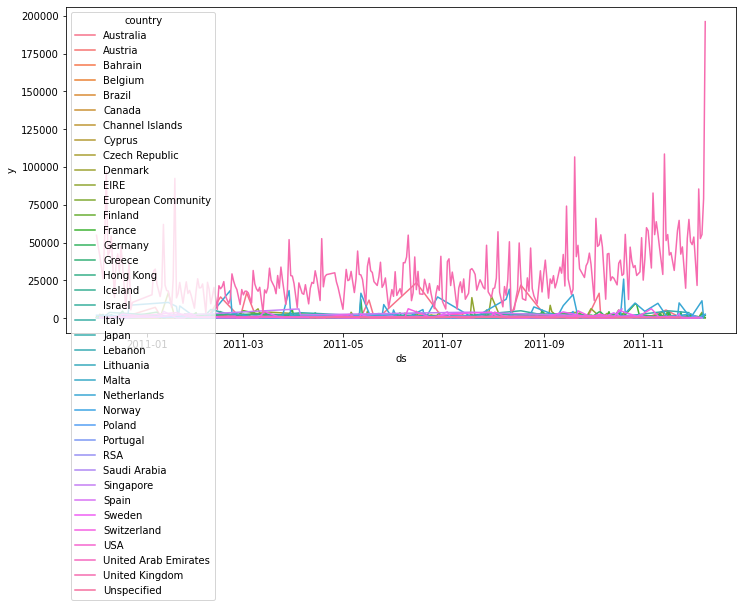

In [17]:
plt.figure(figsize = [12,6])
sns.lineplot(data = cnt, x = 'ds', y = 'y', hue = 'country')

In [18]:
list_country = df['country'].unique()
list_country

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Bahrain', 'Israel', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [33]:
def get_oracle(cnt) :
  
  res = list() 

  for worker in list_country :
    
    try : 
      temp = cnt[cnt.country == worker].reindex(['ds', 'y'], axis = 1)
      m = pr.Prophet().fit(temp)
      future = m.make_future_dataframe(periods=30)
      forecast = m.predict(future)

      oracle = forecast[['ds','yhat', 'trend']]
      oracle.insert(0, 'country', worker)

      oracle = pd.merge(oracle, temp, 'left', 'ds')

      res.append(oracle)
    except : 
      print(f'error : {worker}')
  
  res = pd.concat(res).reset_index().drop(['index'], axis = 1)

  return res

In [34]:
res = get_oracle(cnt)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/b8d6yoqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/zhtfsuj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=376', 'data', 'file=/tmp/tmpdyv3jam1/b8d6yoqh.json', 'init=/tmp/tmpdyv3jam1/zhtfsuj5.json', 'output', 'file=/tmp/tmpdyv3jam1/prophet_modeltxryl0hs/prophet_model-20221114224704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. 

error : Lebanon


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/id24c0f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/fqitkw34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42472', 'data', 'file=/tmp/tmpdyv3jam1/id24c0f7.json', 'init=/tmp/tmpdyv3jam1/fqitkw34.json', 'output', 'file=/tmp/tmpdyv3jam1/prophet_model_ykljrr4/prophet_model-20221114224724.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:47:24 - cmdstanpy - INFO - Chain [1] start processing
INF

error : Saudi Arabia


22:47:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/l6iqmqom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/tov8ijs0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8361', 'data', 'file=/tmp/tmpdyv3jam1/l6iqmqom.json', 'init=/tmp/tmpdyv3jam1/tov8ijs0.json', 'output', 'file=/tmp/tmpdyv3jam1/prophet_modelhpbqw8td/prophet_model-20221114224726.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

error : Brazil


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/jfkd5lu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdyv3jam1/c8b0yhs6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46876', 'data', 'file=/tmp/tmpdyv3jam1/jfkd5lu7.json', 'init=/tmp/tmpdyv3jam1/c8b0yhs6.json', 'output', 'file=/tmp/tmpdyv3jam1/prophet_model8m29oojy/prophet_model-20221114224728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

error : RSA


In [35]:
res.head()

,country,ds,yhat,trend,y
0,United Kingdom,2010-12-01,28819.299933,31047.047360,54818.08
1,United Kingdom,2010-12-02,33283.473744,30972.072602,47570.53
2,United Kingdom,2010-12-03,30026.109843,30897.097845,41308.69
3,United Kingdom,2010-12-05,13779.955668,30747.148330,25853.20
4,United Kingdom,2010-12-06,31585.905598,30672.173572,53322.12


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


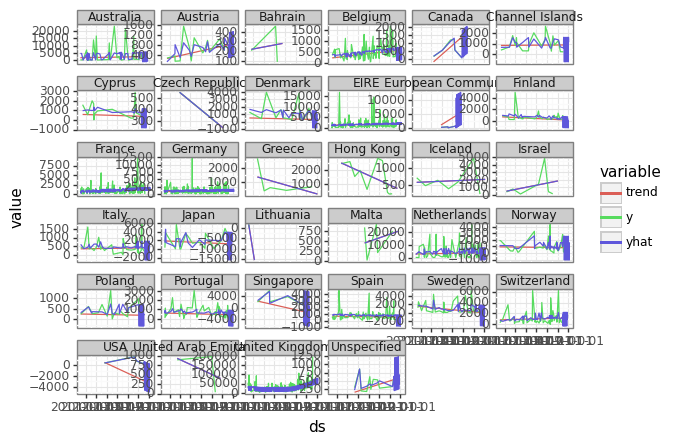

<ggplot: (8735616890805)>

In [41]:
(
    ggplot(pd.melt(res, id_vars = ['country', 'ds']),
           aes('ds', 'value', color = 'variable')) +
    gg.geom_line() +
    gg.facet_wrap('~country', scales = 'free_y') +
    gg.theme_bw()
)

In [43]:
res[res.country == 'Finland']

,country,ds,yhat,trend,y
2032,Finland,2010-12-16,949.527999,678.701037,892.80
2033,Finland,2011-01-21,824.811997,625.147116,661.58
2034,Finland,2011-01-25,1192.547591,619.196680,227.44
2035,Finland,2011-02-24,845.395375,574.568413,205.16
2036,Finland,2011-03-01,1140.481278,567.130368,4969.22
...,...,...,...,...,...
2092,Finland,2011-12-28,444.347906,117.872474,NaN
2093,Finland,2011-12-29,387.211828,116.384865,NaN
2094,Finland,2011-12-30,314.562138,114.897256,NaN
2095,Finland,2011-12-31,-1252.507226,113.409647,NaN


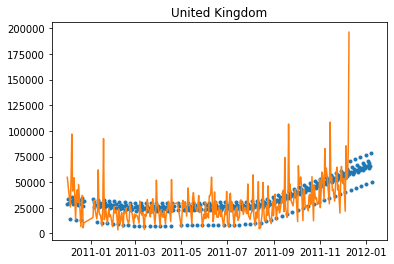

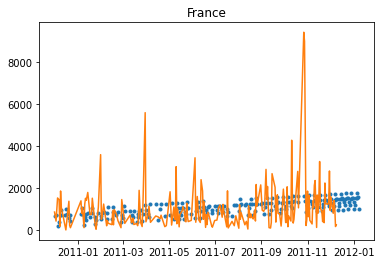

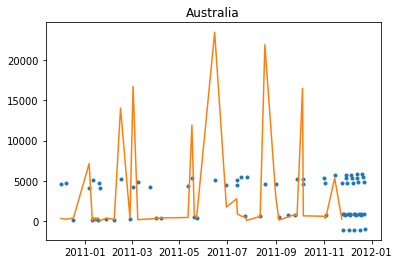

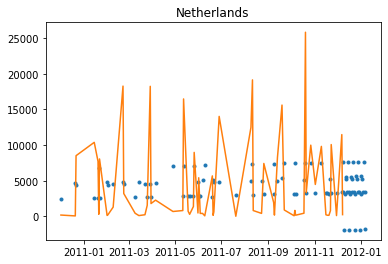

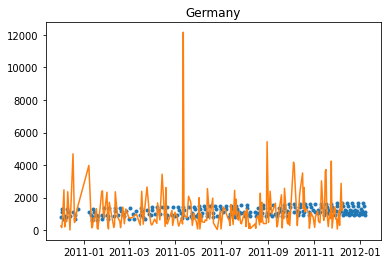

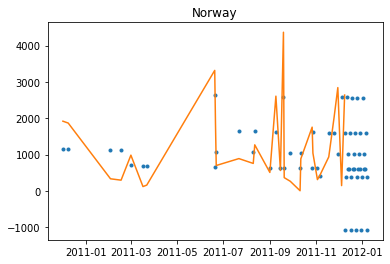

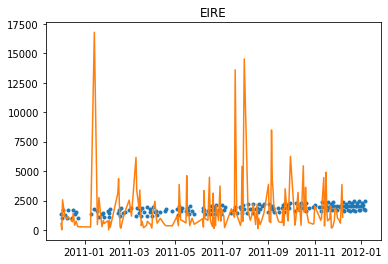

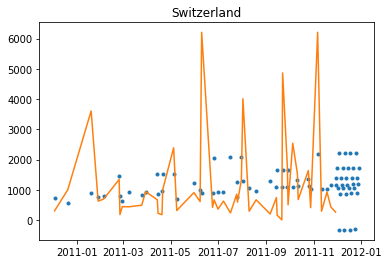

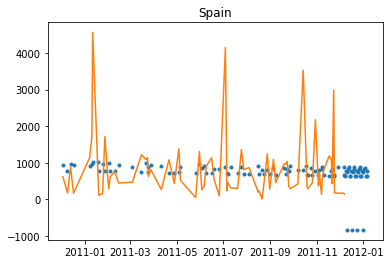

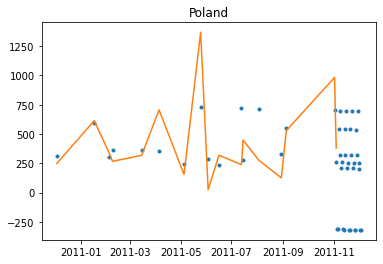

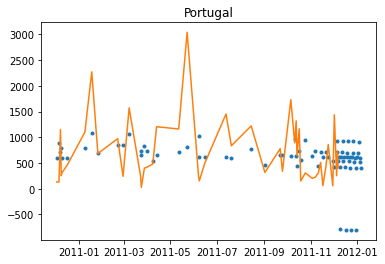

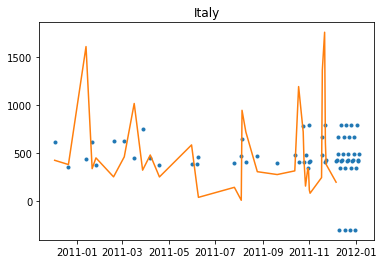

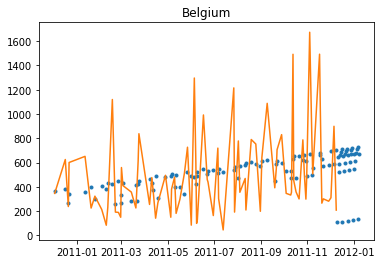

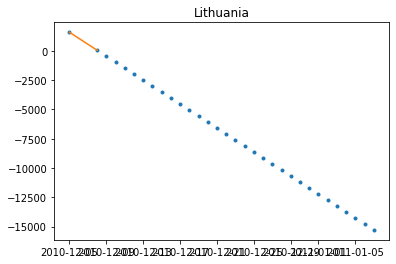

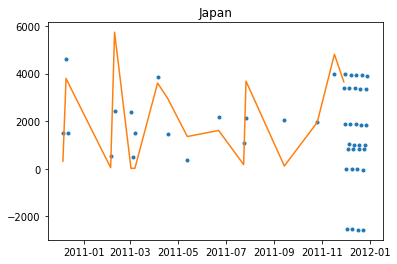

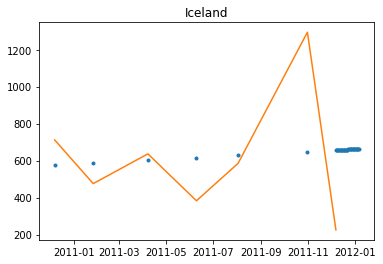

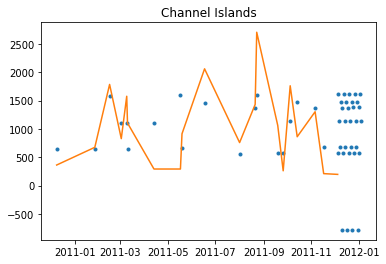

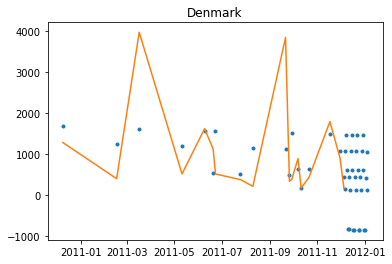

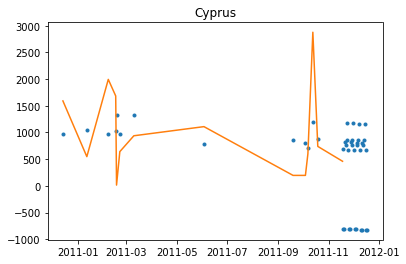

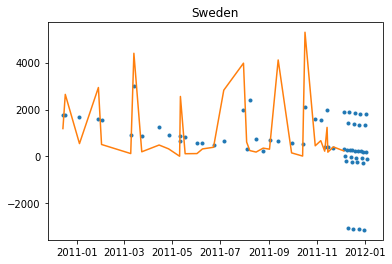

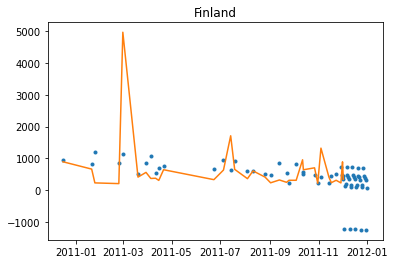

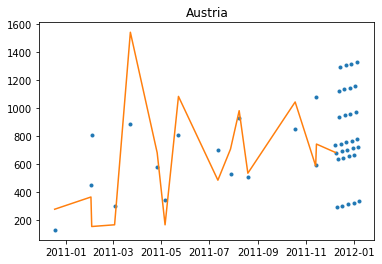

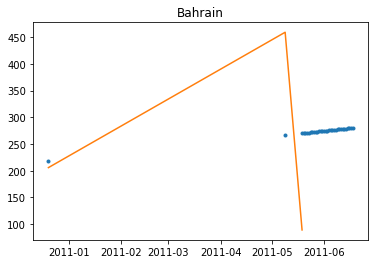

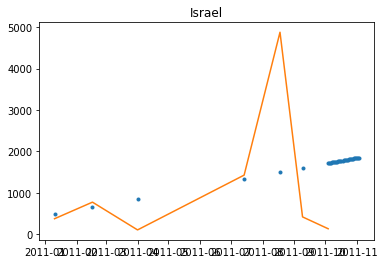

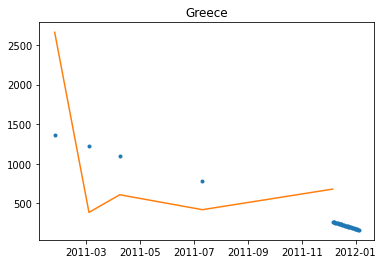

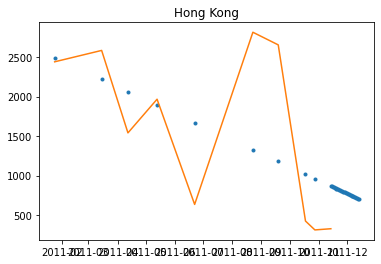

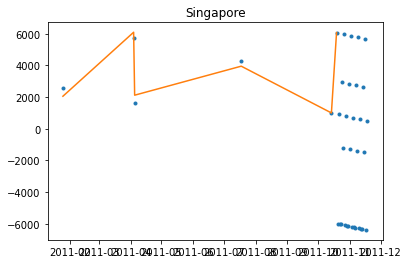

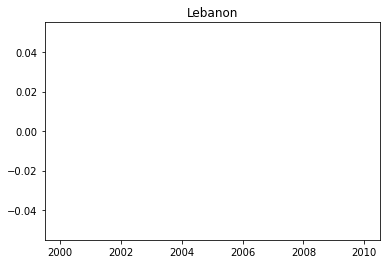

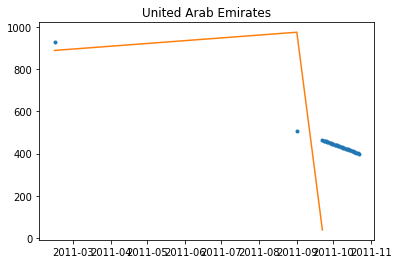

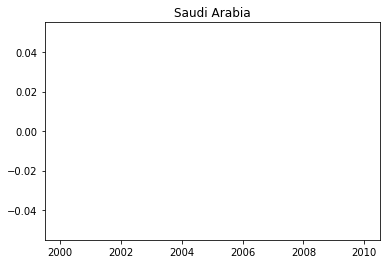

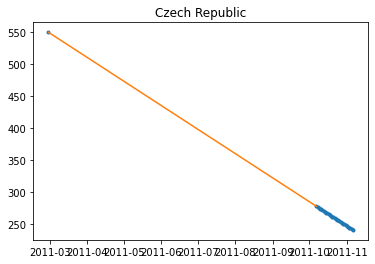

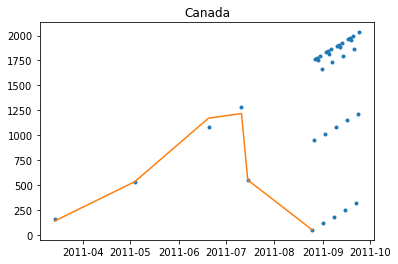

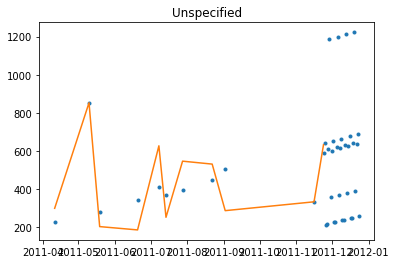

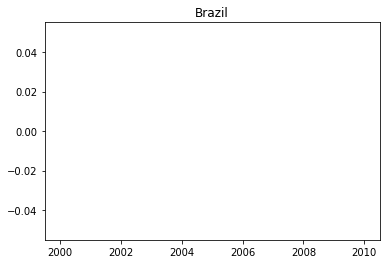

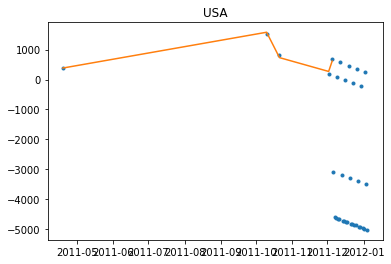

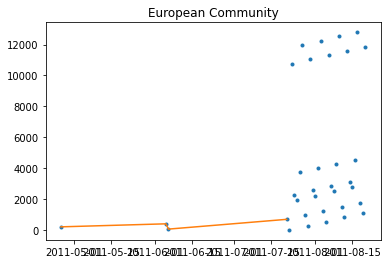

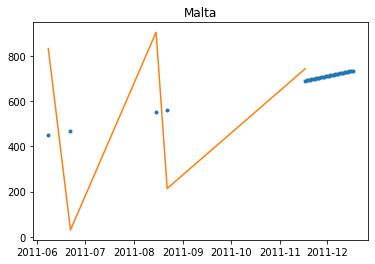

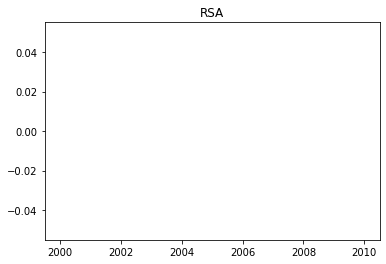

In [49]:
for worker in list_country : 

  plt.title(f'{worker}')
  plt.plot(res[res.country == worker]['ds'], res[res.country == worker]['yhat'], '.')
  plt.plot(res[res.country == worker]['ds'], res[res.country == worker]['y'])
  plt.show()

# Iterator

In [50]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [52]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}